### Урок 7. #Интерпретация прогнозов модели (SHAP) - объясняем поведение модели на отдельных наблюдениях#

Программа урока:

1. Теоретическая часть:
    - Проблема интерпретируемости моделей
    - Примеры, когда это важно
    - Обзор методов

2. Практическая часть:
    - Feature importance, доступный в самих моделях
    - Permutation Importance
    - SHAP

На уроке будет затронут важный для любого бизнеса, применяющего машинное обучение при решении задач, аспект - интерпретируемость моделей. Т.е важно не только умение обучать модели, которые делают качественные прогнозы, но и умение объяснить эти прогнозы. Когда мы не просто понимаем, что пользователь склонен совершить некоторое действие (например, уйти в отток), но и можем выявить факторы, влияющие на это, что позволяет скорректировать стратегию взаимодействия с пользователями (как пример). Такая модель может быть полезна не только своими прогнозами, но и инсайтами, которые скрыты в данных. 

### Проблема интерпретируемости моделей машинного обучения

Интерпретируемость – это возможность объяснить прогнозы модели на понятном бизнесу языке

Черный ящик (так часто видят ML)

![ab_split](blackbox.png "blackbox ML")

Особенности:

1. мы получаем прогнозы, которые приносят пользу (ну, должны)
2. мы не можем внятно объяснить почему прогнозы именно такие и что именно повлияло на принятие решения модели

![ab_split](blackbox2.png "blackbox ML + inter")

Интерпретация прогнозов модели может дать интересные инсайты о том, какая у нас аудитория (вспоминаем uplift-моделирование)

Иногда же на практике интерпретируемость является критичным моментом

Как выглядит процесс: 

1. есть реальный мир
2. мы векторизуем его (как можем - получаем признаки)
3. строим модель
4. интерпретируем
5. объясняем людям поведение модели


![ab_split](inter2.png "inter1")

![ab_split](inter1.png "inter1")

* картинка взята с https://habr.com/ru/company/otus/blog/464695/

### Обзор методов

- важные признаки в модели (feature importance)
- влияние каждого отдельного признака на конкретный прогноз 
- влияние каждого признака на большое количество возможных прогнозов (топ k наблюдений, например)

### 1. Feature importance признаков

Пример с линейной моделью

Набор данных взят отсюда - https://www.kaggle.com/harlfoxem/housesalesprediction

In [3]:
#Colab
#!wget 'https://github.com/Anbionchik/Git_brain_lessons/raw/main/Algorythms_in_business/Les7/kc_house_data.csv' -O 'kc_house_data.csv'

--2023-04-19 05:26:42--  https://github.com/Anbionchik/Git_brain_lessons/raw/main/Algorythms_in_business/Les7/kc_house_data.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Anbionchik/Git_brain_lessons/main/Algorythms_in_business/Les7/kc_house_data.csv [following]
--2023-04-19 05:26:42--  https://raw.githubusercontent.com/Anbionchik/Git_brain_lessons/main/Algorythms_in_business/Les7/kc_house_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2515206 (2.4M) [text/plain]
Saving to: ‘kc_house_data.csv’

kc_house_data.csv   100%[===================>]   2.40M  --.-KB/s    in 0.02s   

2023-0

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
df = pd.read_csv("kc_house_data.csv")
print(df.shape)
df.head(3)

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


В качестве предикторов (признаков) будем использовать 4 - bedrooms, sqft_living, sqft_lot и yr_built

Целевая переменная - price (цена)

In [5]:
features = ["bedrooms", "sqft_living", "sqft_lot", "yr_built"]
target = "price"

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=0)

Соберем пайплайн

In [6]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    

    
continuous_columns = ["bedrooms", "yr_built", 'sqft_living', 'sqft_lot']
final_transformers = list()
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Модель - линейная регрессия

In [7]:
regressor = Pipeline([
    ('features',feats),
    ('classifier', LinearRegression()),
])

In [8]:
#обучим наш пайплайн
regressor.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('bedrooms',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='bedrooms')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('yr_built',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='yr_built')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('sqft_living',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='sqft_living')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('sqft_lot',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='sqft_lot')),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('classifier', LinearRegression())])

Посчитаем MAE и коэффициент детерминации (R2)

In [9]:
predictions =  regressor.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(162462.49573861933, 0.5365765901167387)

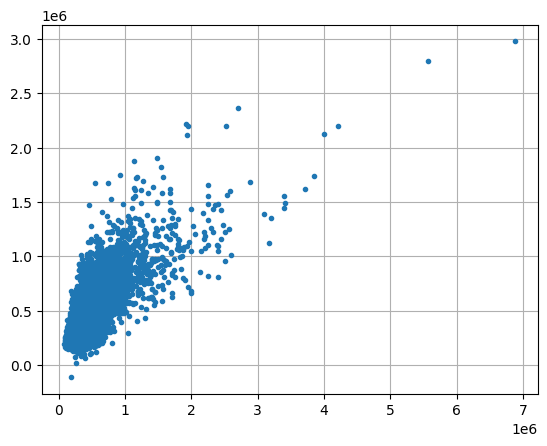

In [10]:
import matplotlib.pyplot as plt
plt.plot(y_test, predictions, '.')
plt.grid()
plt.show()

mae малоинформативен, но вот r2 - очень понятен.

На случай, если кто забыл:

![r2](r2.png "R2 score")

Интерпретация:

1. принимает значения от -1 до 1. Чем ближе к 1, тем лучше модель объясняет данные (соответствует модели данных)
2. значение 1 означает функциональную зависимость y от X
3. В общем случае коэффициент детерминации может быть и отрицательным, это говорит о крайней неадекватности модели: простое среднее приближает лучше

источник на вики - https://ru.wikipedia.org/wiki/Коэффициент_детерминации

Наконец, давайте посмотрим на "важность" признаков (в линейной регрессии это просто веса (коэффициенты) при предикторах (признаках)

Сразу же возьмем абсолютные значения коэффициентов

In [11]:
intercept = regressor[1].intercept_
features = pd.DataFrame(regressor[1].coef_, 
                        continuous_columns, 
                        columns=['coefficient'])
features.sort_values('coefficient', ascending=False)

,coefficient
sqft_living,316113.766523
sqft_lot,-14820.959494
bedrooms,-55705.016661
yr_built,-71039.334129


Как это можно интерпретировать:

1. sqft_living имеет наибольшую важность и положителен (чем выше жилая площадь, тем выше стоимость)
2. остальные признаки уже идут с отрицательным весом
3. вторым по важности признаком является год постройки (yr_built)

### Перейдем к "деревянным" моделям

In [12]:
import xgboost as xgb

In [13]:
regressor = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBRegressor()),
])

#обучим наш пайплайн
regressor.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('bedrooms',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='bedrooms')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('yr_built',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='yr_built')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('sqft_living',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='sqft_living')),
                                                                 ('scale...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [14]:
predictions =  regressor.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(147549.1329252637, 0.5857872837122007)

In [15]:
xgb_features = pd.DataFrame(regressor[1].feature_importances_, 
                        continuous_columns, 
                        columns=['coefficient'])
features.sort_values('coefficient', ascending=False)

,coefficient
sqft_living,316113.766523
sqft_lot,-14820.959494
bedrooms,-55705.016661
yr_built,-71039.334129


Как можно считать feature_importance в моделях на базе деревьев решений

![xgboost](xgboost_tree.png "Xgboost tree")

Ссылка (рекомендую поизучать на досуге) - https://xgboost.readthedocs.io/en/latest/tutorials/model.html

Существует несколько вариантов как для признака в деревьях решений посчитать важность

1. Gain - показывает относительный вклад каждой фичи в модель. 
Алгоритм простой - идем по каждому дереву, смотрим в каждом узле дерева по какому признаку происходит разбиение узла и насколько снижаетcя неопределенность (gini impurity, information gain). Далее для каждого признака суммируется её вклад (по всем деревьям)

2. Frequency - показывает, как часто конкретный признак встречается в узлах дерева, то есть считается суммарное количество разбиений дерева на узлы для каждого признака в каждом дереве.

<b>Вопрос:</b>
Какие еще вы знаете модели со "встроенной" возможностью определять важность признаков?

Ваш ответ:

#### Краткий вывод:

Подходы, основанные на feature_importance, очень удобны, т.к по факту мы получаем готовый функционал и можем хоть какую-то интерпретацию давать без каких-либо внешних инструментов.

Однако проблема такого подхода заключается в том, что непонятно, как именно данная фича влияет на итоговый прогноз. 

Пример: жилая площадь важна для прогноза стоимости жилья, но как именно это может быть связано с другими признаками? Это будет в пункте 3, а сейчас давайте рассмотрим еще один (из множества) способ расчета "важности" признаков

### 2. Permutation importance

Алгоритм очень простой:

- обучаем модель на тренировочном наборе данных
- проверяем качество на валидации
- для валидационного набора данных перемешиваем один из признаков
- снова проверяем качество на нем же

Признак считается «важным», если качество модели падает при его перемешивании.

Очень удобно, что в sklearn есть возможность из коробки такое делать

In [16]:
from sklearn.inspection import permutation_importance
r = permutation_importance(regressor, X_test, y_test,
                            n_repeats=30,
                            random_state=0)

Пример как это может выглядеть на выходе

In [17]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{continuous_columns[i]:<8} "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

yr_built 1.560 +/- 0.043
sqft_lot 0.145 +/- 0.015
sqft_living 0.104 +/- 0.011
bedrooms 0.065 +/- 0.007


Интересно, что результаты немного другие, нежели при использовании "встроенного" feature_importances_)

https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

### SHAP

ссылка на проект - https://github.com/slundberg/shap

Wiki - https://en.wikipedia.org/wiki/Shapley_value

Значения Шэпли пришли к нам из теории игр.

Пример - группа людей (далее - коалиция) играет в игру. 

Необходимо распределить призовой фонд между ними в зависимости от их вклада.

Уточнения (допущения):

- игроки с равным вкладом должны получить одинаковую награду
- если вклад игрока нулевой, то награда также нулевая
- если игрок провел несколько игр, то его награда - это сумма наград за каждую из игр

Немного математики (ссылка - https://en.wikipedia.org/wiki/Shapley_value)

![shap2](shap2.png "SHAP 1")

u - это выигрыш команды

n - количество игроков

S - коалиция (подмножество из n без игрока i)

А теперь попробуем "переложить" все это на вариант с задачей обучения с учителем

- игра - результат обучения с учителем (на основе заданного примера)
#- выигрыш – это разница между матожиданием результата на всех имеющихся примерах и результатом, полученном на заданном примере
- вклады игроков в игру – влияние каждого значения признака на выигрыш, т.е. результат.

Значение Шэпли для i-той фичи рассчитывается для каждого сэмпла данных (каждого наблюдения) на всех возможных комбинациях фичей (включая отсутствие всех фичей), затем полученные значения суммируются по модулю и получается итоговая важность i-той фичи.

Расчет SHAP values очень тяжелый и затратный как по времени так и по ресурсам!

![ab_split](shap1.png "SHAP 1")

SHAP расшифровывается как SHapley Additive explanation. Этот метод помогает разбить на части прогноз, чтобы выявить значение каждого признака. 

Он основан на Векторе Шепли - принципе, используемом в теории игр для определения, насколько каждый игрок при совместной игре способствует ее успешному исходу (https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80). 

### Игрушечный пример 

ссылка - https://arxiv.org/pdf/1802.03888.pdf

![shap4](shap4.png "SHAP 4")

На выходе для комбинации {Fever=Yes, Cough=Yes} хотим получить значимость признаков (т.е для конкретного наблюдения). 

Посчитаем выход модели для каждой возможной комбинации признаков:

![shap4](shap3.png "SHAP 3")

Теперь посчитаем SHAP для признака Fever для модели А (левое дерево).

Для этого посчитаем все необходимое для комбинаций признаков, которые не включают Fever:
![shap4](shap5.png "SHAP 5")

таких у нас 2:
![shap4](shap6.png "SHAP 6")

Подставляем значения в формулу и получаем SHAP для признака Fever:

![shap7](shap7.png "SHAP 7")

А теперь для признака Cough:

![shap8](shap8.png "SHAP 8")

Для модели B (дерево справа) получаем такое:

![shap9](shap9.png "SHAP 9")

Получаем значимость признаков на уровне одного примера с конкретными значениями признаков. 

* phi_0 - ожидаемый результат (для первой модели мы можем попасть в один из 4 листьев - ответ 20, для второй - 25)
* phi - ответ модели для конкретного наблюдения ({Fever=True, Cough=True}) - для первой модели 80, для второй - 90

### Пример (данные оттока с 5 занятия)

In [18]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [24]:
#colab
#!wget 'https://github.com/Anbionchik/Git_brain_lessons/raw/main/Algorythms_in_business/Les7/churn_data.csv' -O 'churn_data.csv'

--2023-04-19 05:29:03--  https://github.com/Anbionchik/Git_brain_lessons/raw/main/Algorythms_in_business/Les7/churn_data.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Anbionchik/Git_brain_lessons/main/Algorythms_in_business/Les7/churn_data.csv [following]
--2023-04-19 05:29:04--  https://raw.githubusercontent.com/Anbionchik/Git_brain_lessons/main/Algorythms_in_business/Les7/churn_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 674856 (659K) [text/plain]
Saving to: ‘churn_data.csv’

churn_data.csv      100%[===================>] 659.04K  --.-KB/s    in 0.01s   

2023-04-19 05:29:04

In [25]:
df = pd.read_csv("churn_data.csv")
features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [26]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df['Exited'], random_state=0)

In [43]:
model = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(X_train, label=y_train), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.initjs()
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

График выше показывает вклад каждого признака в предсказание модели относительно базового значения (средний прогноз по всему тренировочному набору данных). 

- Цвет точки - это значение признака
- То, насколько точка далека от вертикальной линии (серой) влево - показывает ее вклад как отрицательный
- То, насколько точка далека от вертикальной линии (серой) вправо - показывает ее положительный вклад

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


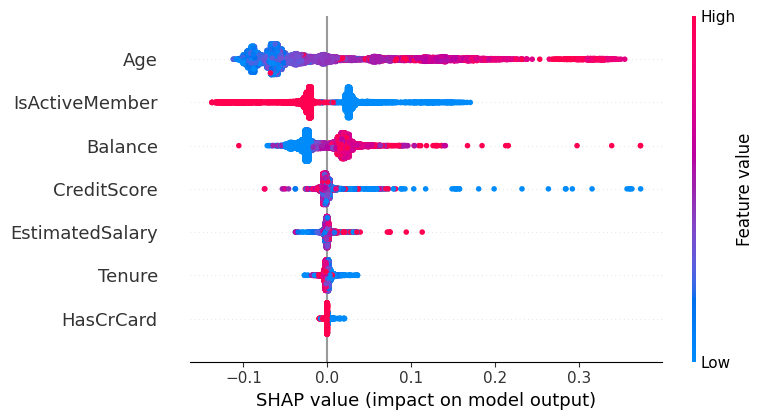

In [28]:
shap.initjs()
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Как его читать: 

- значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точка на графике, тем выше значения признака в ней

Из графика можно сделать интересные выводы и проверить их адекватность:
- чем старше человек, тем выше вероятность ухода
- чем признак IsActiveMember выше, то вероятность ухода ниже
- чем выше баланс, тем выше вероятность ухода (?)

Можно даже просто взять средние значения SHAP для каждого признака

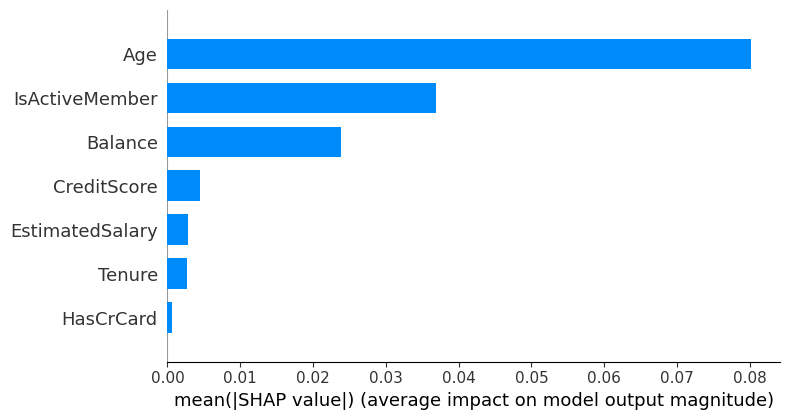

In [29]:
shap.initjs()
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [30]:
#visualize the first prediction's explanation
shap.initjs() #for colab
idx = 100
shap.force_plot(explainer.expected_value, shap_values[idx, :], X_train.iloc[idx, :])

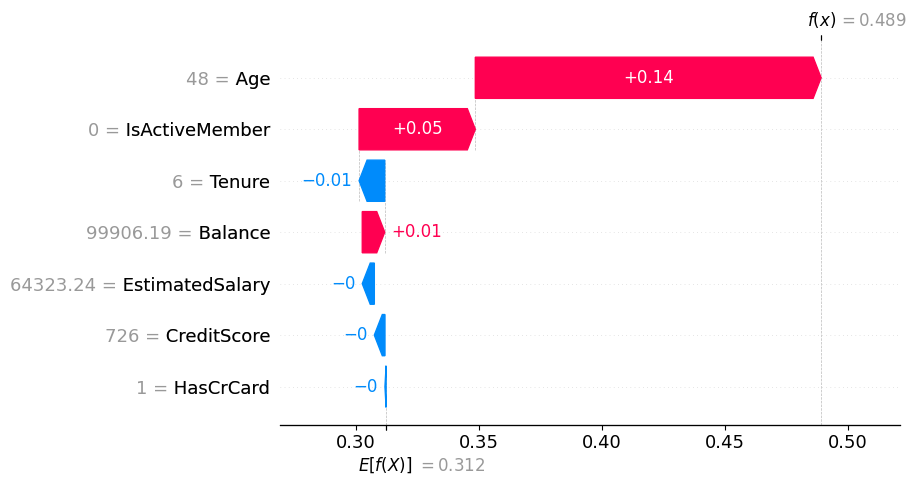

In [31]:
shap.initjs()
shap_values_one = explainer(X_train.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

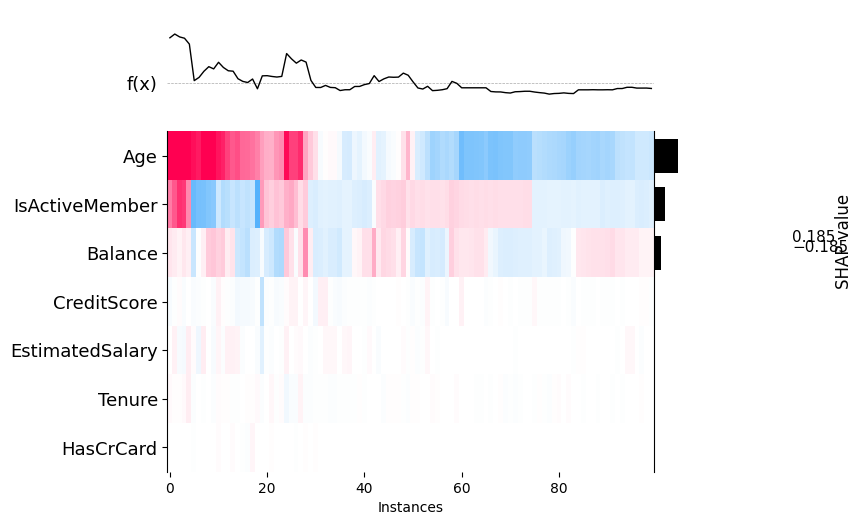

In [32]:
shap.initjs()
n = 100
shap_values_n = explainer(X_train.iloc[:n])
shap.plots.heatmap(shap_values_n)

In [33]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:n], X_train.iloc[:n])

In [34]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107747 sha256=51c184648920cc03cded60a31c0967bb356300454e043fb8826b098a7e6d3635
  Stored in directory: /root/.cache/pip/wheels/7b/26/a5/8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5


Библиотека позволяет анализировать веса модели для оценивания поведения модели.

In [35]:
import eli5
eli5.show_weights(model, feature_names=X_train.columns.tolist())

Weight,Feature
0.4112,IsActiveMember
0.3962,Age
0.0622,Balance
0.0356,CreditScore
0.0340,Tenure
0.0332,EstimatedSalary
0.0275,HasCrCard


Позволяет анализировать вклад признаков и их значений у конкретного объекта.

In [36]:
idx= 10
eli5.show_prediction(model, X_train.iloc[idx], feature_names=X_train.columns.tolist(),
                    show_feature_values=True)

explain_weights_sklearn() - методо, позволяющий вернуть explainer объект. Можно накладывать на него форматирования

In [37]:
from sklearn.tree import DecisionTreeClassifier

n=100
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train.iloc[:n], y_train[:n])

DecisionTreeClassifier(random_state=42)

In [38]:
explanation = eli5.explain_weights_sklearn(tree_model, feature_names=X_train.columns.tolist())

In [39]:
from eli5.formatters import format_as_dataframe

format_as_dataframe(explanation)

,feature,weight
0,CreditScore,0.309575
1,Age,0.248007
2,EstimatedSalary,0.198607
3,Balance,0.107240
4,IsActiveMember,0.071216
5,Tenure,0.065355
6,HasCrCard,0.000000


In [40]:
from eli5.formatters import format_as_text

print(format_as_text(explanation))

Explained as: decision tree

Decision tree feature importances; values are numbers 0 <= x <= 1;
all values sum to 1.

0.3096  CreditScore
0.2480  Age
0.1986  EstimatedSalary
0.1072  Balance
0.0712  IsActiveMember
0.0654  Tenure
     0  HasCrCard

Age <= 37.500  (47.0%)
    Tenure <= 1.500  (4.0%)
        IsActiveMember <= 0.500  (1.0%)  ---> 1.000
        IsActiveMember > 0.500  (3.0%)  ---> 0.000
    Tenure > 1.500  (43.0%)
        CreditScore <= 722.000  (31.0%)  ---> 0.000
        CreditScore > 722.000  (12.0%)
            CreditScore <= 726.500  (1.0%)  ---> 1.000
            CreditScore > 726.500  (11.0%)  ---> 0.000
Age > 37.500  (53.0%)
    Balance <= 115596.574  (33.0%)
        CreditScore <= 775.500  (31.0%)
            CreditScore <= 532.000  (4.0%)
                EstimatedSalary <= 155196.945  (3.0%)  ---> 1.000
                EstimatedSalary > 155196.945  (1.0%)  ---> 0.000
            CreditScore > 532.000  (27.0%)
                EstimatedSalary <= 9602.615  (1.0%)  ---

In [41]:
from eli5.formatters import format_as_html
from IPython.display import display, HTML

html_rep = format_as_html(explanation)
display(HTML(data=html_rep))

Weight,Feature
0.3096,CreditScore
0.2480,Age
0.1986,EstimatedSalary
0.1072,Balance
0.0712,IsActiveMember
0.0654,Tenure
0,HasCrCard


## LIME 
Ещё один фреймфорк, но лень его сюда переписывать, делает то же самое

### Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


In [44]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [47]:
df.rename(columns={'DEATH_EVENT':'target'}, inplace=True)

In [62]:
df['target'].value_counts()

0    203
1     96
Name: target, dtype: int64

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  target                    299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [65]:
continuous_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
categorical_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], train_size=0.3, random_state=42)

In [78]:
final_transformers = list()
    
for cont_col in continuous_features:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

for cat_col in categorical_features:
    cat_transformer = Pipeline([
                ('selector', NumberSelector(key=cat_col)),
                ('OHEEncoder', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [79]:
from sklearn.ensemble import RandomForestClassifier

In [80]:
classifier = Pipeline([('features', feats),
                       ('classifier', RandomForestClassifier())])

In [86]:
classifier.fit(X_train, y_train)
y_preds = classifier.predict_proba(X_test)[:,1]

In [100]:
from sklearn.preprocessing import FunctionTransformer
names = X_train.columns.to_list()
pipe_preprocessor = Pipeline([("preprocessor", feature_processing), ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = names)))]).fit(X_train)

In [124]:
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [131]:
from joblib import Parallel, delayed, _fit_transform_one, _transform_one, sparse
class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(trans, weight, X, y,
                                        **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(trans, weight, X)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

ImportError: ignored

In [129]:
pandas_feats = PandasFeatureUnion(final_transformers)

In [130]:
pandas_feats.fit_transform(X_train)

NameError: ignored

In [88]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

precision, recall, thresholds = precision_recall_curve(y_test, y_preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
roc_auc = roc_auc_score(y_test, y_preds)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}, ROC-AUC={roc_auc:.3f}')

Best Threshold=0.22, F-Score=0.765, Precision=0.663, Recall=0.903, ROC-AUC=0.896


In [90]:

explainer = shap.TreeExplainer(RandomForestClassifier)
shap_values = explainer.shap_values(X_train)
shap.initjs()
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.summary_plot(shap_values[0,:], X_train.iloc[0,:])

InvalidModelError: ignored

Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

Feature selection:

1. RFE - recursive feature elimination (есть в sklearn)
2. Boruta - shadow features
3. Target permutation 